In [123]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# (Optional) Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# StandardScaler
from sklearn.preprocessing import StandardScaler

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

import os

In [124]:
#Check working directory

print(os.getcwd())


/Users/eugenechua/Downloads/Chief People Officer


In [125]:
df = pd.read_csv("employee_data.csv")
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [126]:
df.isnull().sum().sort_values()

avg_monthly_hrs          0
n_projects               0
salary                   0
status                   0
satisfaction           181
tenure                 181
department             709
last_evaluation       1532
filed_complaint      12191
recently_promoted    13949
dtype: int64

In [127]:
(df.isnull().sum()/len(df)).sort_values()

avg_monthly_hrs      0.000000
n_projects           0.000000
salary               0.000000
status               0.000000
satisfaction         0.012703
tenure               0.012703
department           0.049758
last_evaluation      0.107516
filed_complaint      0.855569
recently_promoted    0.978946
dtype: float64

There are so many *NaN* values especially for **filed_complaints** and **recently_promoted** fields. Let us try replacing them.

In [128]:
df.filed_complaint.fillna(0, inplace=True)
df.recently_promoted.fillna(0, inplace=True)

In [129]:
df['salary_numeric'] = df.salary.replace({'low': 0, 'medium': 1, 'high': 2})

In [130]:
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1532
n_projects              0
recently_promoted       0
salary                  0
satisfaction          181
status                  0
tenure                181
salary_numeric          0
dtype: int64

I can work with this level of missings.

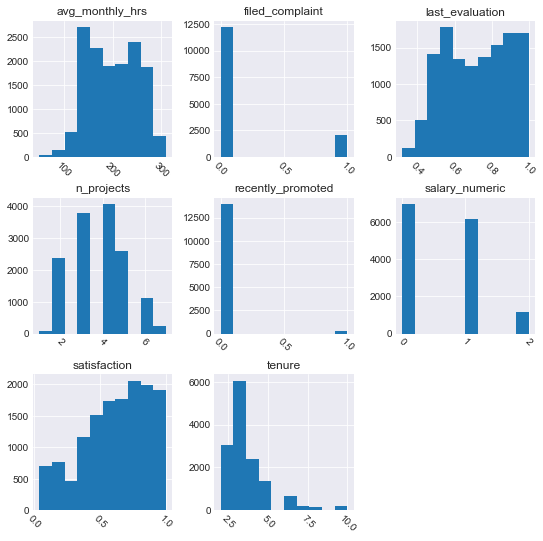

In [131]:
# Plot histogram grid
df.hist(figsize=(9,9), xrot=-45)

# Clear the text "residue"
plt.show()

One thing that struck out to me is that most employees do not appear long *past the 5 years mark)*

In [132]:
df['status'].value_counts()

Employed    10857
Left         3392
Name: status, dtype: int64

Lets do a percentage breakdown to have a clearer overview

In [133]:
df['status'].value_counts(normalize=True)

Employed    0.761948
Left        0.238052
Name: status, dtype: float64

Some of the fields are pretty skewed, so we have to take note of these. *status, filed_complaint, tenure* etc.

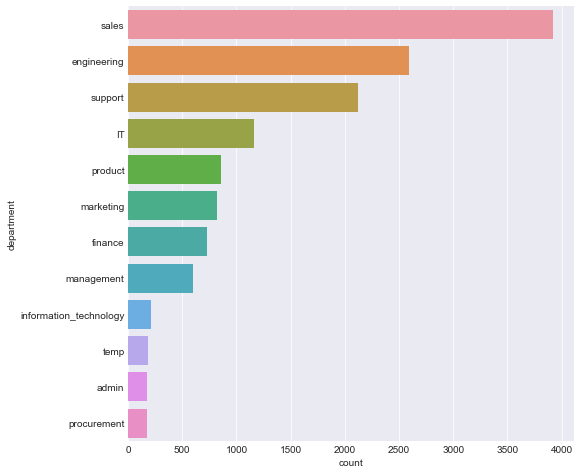

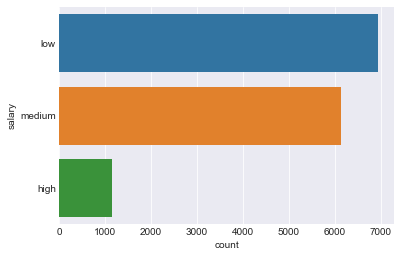

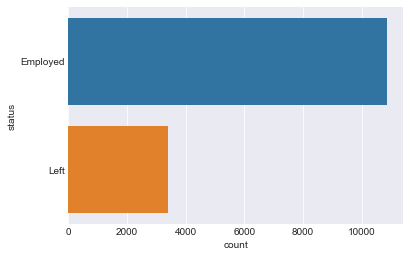

In [134]:
plt.figure(figsize=(8,8))


for feature in df.dtypes[df.dtypes == 'object'].index:
    sns.countplot(y=feature, data=df,order=df[feature].value_counts().index)
    plt.show()
        


- Are there any classes that might be sparse?
- Are there any classes that shouldn't be in the dataset based on our project scope? (Hint: there's 1... can you find it?)
- Are there any mislabeled classes (i.e. two classes that are essentially the same)?

There do not appear to be sparse classes, but there does appear to be observations from temp employees; albeit on the low side, which is outside the project scope. Our client only cares about permanent, non-temp employees. In addition, there also appears to be a mislabeled class, as 'IT' and 'information_technology' refer to the same department.

### Simple Segmentation

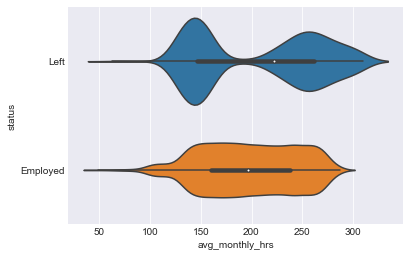

In [135]:
# Segment satisfaction by status and plot distributions
sns.violinplot(y='status', x='avg_monthly_hrs', data=df)
plt.show()


we can see those who left the organisation largely fell into 2 main camps. Those who are clearly overworking and those who are *slacking off* maybe a little..


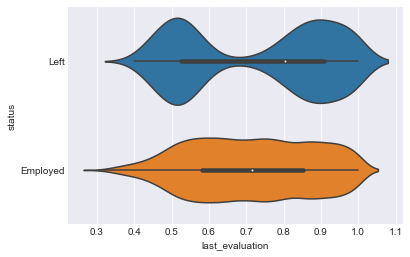

In [136]:
# Segment last_evaluation by status and plot distributions
sns.violinplot(y='status', x='last_evaluation', data=df)
plt.show()

Look at this now. We can see that those who left the organisation are those *stellar performers* or those *under performers*.

In [137]:
#Replace information technology with IT! and removing temp workers

df.department.replace('information_technology', 'IT', inplace=True)
df = df[df.department != 'temp']


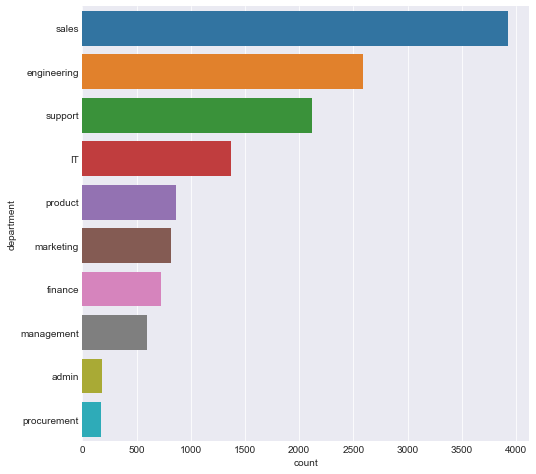

In [138]:
plt.figure(figsize=(8,8))

sns.countplot(y='department', data=df,order=df['department'].value_counts().index)
plt.show()


From the count plots above, we can see that temp workers are taken out of the equations. Also information technology has been replaced with IT.

Lets say now we are curious to examine the average hours work for each department class?

In [139]:
df.groupby('department').mean().sort_values(by='avg_monthly_hrs')

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,salary_numeric
department,,,,,,,,
procurement,199.482759,0.183908,0.699205,3.885057,0.057471,0.627930,3.264368,0.557471
marketing,199.664225,0.159951,0.715018,3.687424,0.048840,0.629122,3.567766,0.620269
product,199.991860,0.151163,0.719616,3.817442,0.000000,0.628774,3.487209,0.577907
sales,200.842467,0.141728,0.711254,3.772878,0.024726,0.623075,3.527148,0.556207
support,200.975495,0.155042,0.723200,3.804430,0.008483,0.626923,3.394910,0.554194
management,201.025210,0.173109,0.729714,3.857143,0.114286,0.630428,4.294118,1.057143
finance,201.175824,0.119505,0.723880,3.815934,0.019231,0.586787,3.543956,0.641484
admin,201.272727,0.096591,0.726282,3.897727,0.028409,0.611450,3.369318,0.596591
IT,202.174453,0.140876,0.720017,3.810219,0.005109,0.628079,3.456204,0.572263


Seems that for engineering, you work till u drop.

### Advanced Segmentation

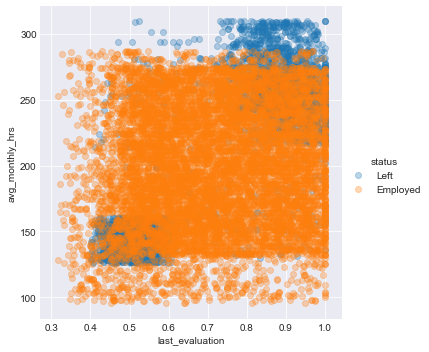

In [140]:
# Scatterplot of last_evaluation vs. avg_monthly_hrs
sns.lmplot(x='last_evaluation',
           y='avg_monthly_hrs',
           hue='status',
           data=df,
           fit_reg=False,
           scatter_kws={'alpha':0.3})
plt.show()

The above chart is meant to showcase the relationship between *last evaluation* and *avg_monthly_hrs*, but most unfortunately, the graph is too cluttered.

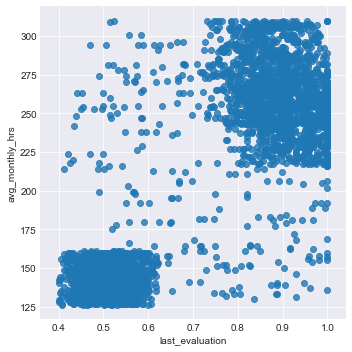

In [141]:
# Scatterplot of last_evaluation vs. avg_monthly_hrs for leavers
sns.lmplot(x='last_evaluation', y='avg_monthly_hrs', data=df[df.status=='Left'], fit_reg=False)
plt.show()

We see *superstars* and *slackers* in this graph!

In [142]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,salary_numeric
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,Left,5.0,0
1,232,support,0.0,NaN,3,0.0,low,0.834544,Employed,2.0,0
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,Employed,3.0,1
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,Employed,2.0,0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,Employed,3.0,0


In [143]:
df.shape

(14068, 11)

In [144]:
df.drop_duplicates(inplace=True)
print(df.shape)

(14068, 11)


It appears that there are no duplicates observations in the dataset.

### Fixing missings and feature engineering

In [145]:
# Display number of missing values by feature
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
salary_numeric          0
dtype: int64

You can see that there are still missing values in both departments and last_evaluation features. Let us deal with them separately.

In [146]:
# Fill missing values in department with 'Missing'
df['department'].fillna('Missing', inplace=True)

In [147]:
# Indicator variable for missing last_evaluation
df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)

Let us flag any missing observations for last_evaluations as a separate indicator variable itself, this will be of use to us during the later feature engineeting process.

Meanwhile, I will also fill in the original missing values with 0 so the algorithms can run properly. Prior to that, let us run a scatterplot between *last_evaluation* and *satisfaction*. We have previously already ran several plots against *last evaluation* but have not yet tried anything with *satisfaction*. I have a strong hypothesis that there will definitely be some kind of relationship between *last evaluation* and *satisfaction* scores.

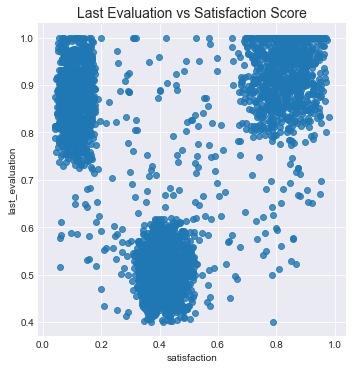

In [148]:
sns.lmplot(x="satisfaction",y="last_evaluation",data=df[df.status=="Left"],
          fit_reg=False)

plt.title("Last Evaluation vs Satisfaction Score",fontsize=14)

plt.show()

Now, I will properly replace those missing *last evaluation* values with 0s.

In [149]:
# Fill missing values in last_evaluation with 0
df.last_evaluation.fillna(0, inplace=True)

In [150]:
# Display number of missing values by feature
df.isnull().sum()

avg_monthly_hrs            0
department                 0
filed_complaint            0
last_evaluation            0
n_projects                 0
recently_promoted          0
salary                     0
satisfaction               0
status                     0
tenure                     0
salary_numeric             0
last_evaluation_missing    0
dtype: int64

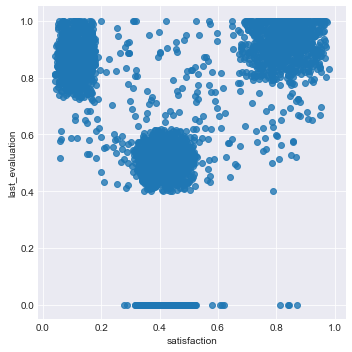

In [151]:
# Scatterplot of satisfaction vs. last_evaluation, only those who have left
sns.lmplot(x='satisfaction',
           y='last_evaluation',
           data=df[df.status == 'Left'],
           fit_reg=False)
plt.show()

Why does the plot looks differently now?

This is because, we have flagged and filled missing values for last_evaluation with 0.

 - First, we have people with high 'last_evaluation' but low 'satisfaction'. Maybe these people were *overqualified, frustrated, or unhappy* in some other way.
 
- Next, we have people with low 'last_evaluation' and medium 'satisfaction'. These were probably *underperformers* or poor cultural fits.


- Finally, we have people with high 'last_evaluation' and high 'satisfaction'. Perhaps these were *overachievers* who found better offers elsewhere.

These roughly translate to 3 indicator features we can engineer:

- 'underperformer' - last_evaluation < 0.6 and last_evaluation_missing == 0

- 'unhappy' - satisfaction_level < 0.2

- 'overachiever' - last_evaluation > 0.8 and satisfaction > 0.7

In [152]:
# Create indicator features
df['underperformer'] = ((df.last_evaluation < 0.6) & 
                        (df.last_evaluation_missing == 0)).astype(int)

df['unhappy'] = ((df.satisfaction < 0.2) & (df.last_evaluation > 0.6)).astype(int)

df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

In [153]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,salary_numeric,last_evaluation_missing,underperformer,unhappy,overachiever
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,Left,5.0,0,0,0,0,1
1,232,support,0.0,0.000000,3,0.0,low,0.834544,Employed,2.0,0,1,0,0,0
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,Employed,3.0,1,0,0,0,0
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,Employed,2.0,0,0,1,0,0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,Employed,3.0,0,0,0,0,1


One of the final feature engineering we have got to do now is to convert the dependent variable to binary 0/1 in nature. whereby 1 will be those who have left the organisation and 0 will be those who are still around.

In [154]:
df['status'].value_counts()

Employed    10701
Left         3367
Name: status, dtype: int64

In [155]:
df['status'] = df['status'].replace({'Left':1,'Employed':0})

df['status'].value_counts()

0    10701
1     3367
Name: status, dtype: int64

In [156]:
# Create new dataframe with dummy features
df = pd.get_dummies(df, columns=['department', 'salary'])

# Display first 10 rows
df.head(10)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,salary_numeric,last_evaluation_missing,underperformer,unhappy,overachiever,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


Now we will start prepping the data file to train some models.

In [157]:
# Create separate object for target variable
y = df['status']

# Create separate object for input features
X = df.drop('status', axis=1)

In [158]:
# Split X and y into train and test sets
#Using stratify sampling here!
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=df['status'])

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test) )

11254 2814 11254 2814


Now we will start building the model pipelines.

I wll be using the following keys:

- 'l1' for L1 regularized logistic regression
- 'l2' for L2 regularized logistic regression
- 'rf' for random forest
- 'xgb'for extreme gradient boosting

In [159]:
# Pipeline dictionary
pipelines = {
    'l1' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l1' , solver = 'liblinear', random_state=123)),
    'l2' : make_pipeline(StandardScaler(), 
                         LogisticRegression(penalty='l2' , random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'xgb': make_pipeline(StandardScaler(),XGBClassifier(objective='binary:logistic',random_state=123))
}

In [160]:
pipelines['xgb'].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('xgbclassifier', XGBClassifier(random_state=123))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'xgbclassifier': XGBClassifier(random_state=123),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'xgbclassifier__base_score': 0.5,
 'xgbclassifier__booster': 'gbtree',
 'xgbclassifier__colsample_bylevel': 1,
 'xgbclassifier__colsample_bytree': 1,
 'xgbclassifier__gamma': 0,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_delta_step': 0,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__missing': None,
 'xgbclassifier__n_estimators': 100,
 'xgbclassifier__n_jobs': 1,
 'xgbclassifier__nthread': None,
 'xgbclassifier__objective': 'binary:logistic',
 'xgbclassifier__random_state': 123,
 'xgbclassifier__reg_alpha': 0,
 'xgbclassifier__reg_lambda': 1,
 'xgbclassifier__scale_pos_weight': 1,
 'xgbclassifier__seed': 

In [161]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
}

l2_hyperparameters = {
    'logisticregression__C' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
}

Remember for a linear regression problem, we will be tuning the *alpha* but  given that this is a logistic regression  we are tuning the *C*.

- *C* is basically the inverse of the regularization strength
- Basically this means the higher value of C means the weaker the penalty or *regularization*

In [162]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_features': ['auto', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]
}

For a random forest, there are many more hyperparameters that we can potentially look at. But the 3 most important hyperparameters are the following:

- *n estimators*: This is basically the number of trees the random forest algorithm forest algorithm builds before taking the average of the predictions. In general, a higher number of trees increases the performance and makes the prediction more stable, but it also slows down the computation.

- *max features*: This is the maximum number of features random forest considers to split a node. Remember for each iteration, the random forest randomly select a subset of features to build each tree.

- *min sample leaf*: This determines the minimum number of leaves required to split an internal node.

In [163]:
# Boosted Tree hyperparameters
xgb_hyperparameters = {
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__learning_rate': [0.05, 0.1, 0.15],
    'xgbclassifier__max_depth': [1, 3, 5]
}

Similarly for XGBoosting, we also have got a couple of hyperparameters to tune. We will focus on *n_estimators* which allow us to control how many trees we wanna build, *max_depth* which allows us to determine how deeply each tree is allowed to grow during each boosting round, and *learning_rate* which is a step size shrinkage used to prevent overfitting. 

In [164]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'xgb': xgb_hyperparameters
}

Next, I will be creating a *fitted_models* dictionary that includes models that have being tuned using cross validation.

In [165]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

l1 has been fitted.
l2 has been fitted.
rf has been fitted.
xgb has been fitted.


In [166]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

l1 0.8579171726146404
l2 0.8580060615035293
rf 0.9788521052371785
xgb 0.9760086480082926


Finally, it is time to evaluate the models and pick up the best ones. We will evaluate the models by looking at the cross validated performance on the training set. These are basically the average accuracy from the holdout folds, the higher is definitely better. Random Forest appears to be performing well.

In [167]:
# Predict classes using L1-regularized logistic regression 
pred = fitted_models['l1'].predict(X_test)

# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[1984  157]
 [ 201  472]]


In [168]:
# Predict classes using L2-regularized logistic regression 
pred = fitted_models['l2'].predict(X_test)

# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[1984  157]
 [ 201  472]]


In [169]:
# Predict classes using the random forest
pred = fitted_models['rf'].predict(X_test)

# Display confusion matrix for y_test and pred
print( confusion_matrix(y_test, pred) )

[[2131   10]
 [  48  625]]


In [170]:
#Predict classes using XGBoosting
pred = fitted_models['xgb'].predict(X_test)

#Display confusion matrix for y_test and pred
print(confusion_matrix(y_test,pred))

[[2123   18]
 [  46  627]]


In [171]:
#RF Testing Accuracy
(2131 + 625)/(2131 + 10 + 48 + 625)

0.9793887704335466

In [172]:
#RF Testing Recall - We are focusing on maximizing Recall because we would want to reduce number of false negative
(625)/(625+48)

0.9286775631500743

In [173]:
#XGB Testing Accuracy
(2123 + 627)/(2123 + 18 + 46 + 627)

0.9772565742714996

In [174]:
#XGB Testing recall
(627)/(627 + 46)

0.9316493313521546

In terms of *Accuracy*, the Random Forest was marginally better than XGBoosting. But in terms of *Recall* the XGBoosting model performed marginally better than the random forest model. In this scenario, where we are more worried about letting false negative cases slipping through the crack, we might have a stronger preference for the XGBoosting model.

### ROC Curves

Now, let us try calculating the ROC curve for my L1-regularized logistic regression using the *roc_curve* function which I had imported earlier.

In [175]:
pred = fitted_models['l1'].predict_proba(X_test)

#Getting the predictions for the positive class
pred = [p[1] for p in pred]

#Checking the first 5 predictions
print(np.round(pred[:5],2))

[0.03 0.   0.01 0.06 0.06]


In [176]:
#Calculating the fpr, tpr and threshold from the roc_curve

fpr,tpr,thresholds = roc_curve(y_test,pred)

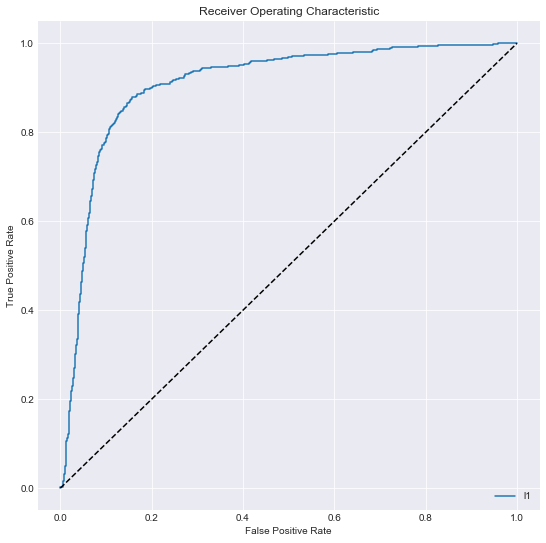

In [177]:
plt.figure(figsize=(9,9))
plt.title("Receiver Operating Characteristic")

#Plot ROC Curve
plt.plot(fpr,tpr,label='l1')
plt.legend(loc="lower right")

#Plotting the 45 degrees line
plt.plot([0,1],[0,1],'k--')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.show()

The main problem with raw accuracy is that it only accounts for TRUE positives/negatives, while not accounting for FALSE positives/negatives at all. We need a metric that accounts for all of that available performance information.

Area Under ROC Curve (AUROC) is the more reliable metric for classification tasks.

Area Under ROC Curve (AUROC) is equivalent to the probability that a randomly chosen positive class observation ranks higher (has a higher predicted probability) than a randomly chosen negative class observation. So basically, it tells us how much the model is capable of distinguising between classes. The higher the AUC score, the better the model is in predicting 1 as 1s and 0 as 0s. Most importantly of all AUROC is slightly more robust against imbalanced classes which we are seeing here.

To evaluate the classification performance of all the four algorithms, I will use a for loop to print the AUROC performance of each model in *fitted_models* on the test set.

In [179]:
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    print(name, roc_auc_score(y_test, pred))

l1 0.907482373777928
l2 0.9074872318763434
rf 0.9925261625950019
xgb 0.9884960229524331


From here we can see that Randon Forest is the slightly better model here, with AUROC score of around 0.992. This tells us that the Random Forest has got a 99.2% chance of distingushing a positive class observation (Employees who are leaving) from a negative class observation (Employees who are not leaving). 

However, as I had mentioned earlier on, the interpretation of all these classification metrics eventually boil down to the business requirements. What are we trying to acheive here? We are trying to predict the likelihood of an employee leaving the organisation and in this case, the costs of wrongly predicting an employee as not leaving the organisation **(False Negative)** when he/she is in fact intending to leave will be much heftier than if we got the prediction of an employee not leaving the organisation wrongly.
